# **Customer Conversion Prediction**

# Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from itertools import combinations
import streamlit as st
import pickle

# Loading the dataset

In [2]:
df = pd.read_csv('ccp.csv')

In [3]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


# Data cleaning

In [4]:
df.shape

(45211, 11)

In [5]:
df.isnull().sum()

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

In [6]:
df = df.drop_duplicates()
df.shape

(45205, 11)

In [7]:
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

In [8]:
df.describe()

,age,day,dur,num_calls
count,45205.000000,45205.00000,45205.000000,45205.000000
mean,40.937087,15.80688,258.183055,2.763898
std,10.619130,8.32234,257.538504,3.098189
min,18.000000,1.00000,0.000000,1.000000
25%,33.000000,8.00000,103.000000,1.000000
50%,39.000000,16.00000,180.000000,2.000000
75%,48.000000,21.00000,319.000000,3.000000
max,95.000000,31.00000,4918.000000,63.000000


In [9]:
# age
iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
print('IQR :',iqr)
upper_threshold = df['age'].quantile(0.75) + (1.5 * iqr)
print('Upper Threshold :',upper_threshold)
lower_threshold = df['age'].quantile(0.25) - (1.5 * iqr)
print('Lower Threshold :',lower_threshold)

IQR : 15.0
Upper Threshold : 70.5
Lower Threshold : 10.5


In [10]:
# day
iqr = df['day'].quantile(0.75) - df['day'].quantile(0.25)
print('IQR :',iqr)
upper_threshold = df['day'].quantile(0.75) + (1.5 * iqr)
print('Upper Threshold :',upper_threshold)
lower_threshold = df['day'].quantile(0.25) - (1.5 * iqr)
print('Lower Threshold :',lower_threshold)

IQR : 13.0
Upper Threshold : 40.5
Lower Threshold : -11.5


In [11]:
# dur
iqr = df['dur'].quantile(0.75) - df['dur'].quantile(0.25)
print('IQR :',iqr)
upper_threshold = df['dur'].quantile(0.75) + (1.5 * iqr)
print('Upper Threshold :',upper_threshold)
lower_threshold = df['dur'].quantile(0.25) - (1.5 * iqr)
print('Lower Threshold :',lower_threshold)

IQR : 216.0
Upper Threshold : 643.0
Lower Threshold : -221.0


In [12]:
df['dur'] = df['dur'].clip(-221, 643)

In [13]:
# num_calls
iqr = df['num_calls'].quantile(0.75) - df['num_calls'].quantile(0.25)
print('IQR :',iqr)
upper_threshold = df['num_calls'].quantile(0.75) + (1.5 * iqr)
print('Upper Threshold :',upper_threshold)
lower_threshold = df['num_calls'].quantile(0.25) - (1.5 * iqr)
print('Lower Threshold :',lower_threshold)

IQR : 2.0
Upper Threshold : 6.0
Lower Threshold : -2.0


In [14]:
df['num_calls'] = df['num_calls'].clip(-2,6)

In [15]:
df.describe()

,age,day,dur,num_calls
count,45205.000000,45205.00000,45205.00000,45205.000000
mean,40.937087,15.80688,234.95620,2.392235
std,10.619130,8.32234,176.75476,1.600152
min,18.000000,1.00000,0.00000,1.000000
25%,33.000000,8.00000,103.00000,1.000000
50%,39.000000,16.00000,180.00000,2.000000
75%,48.000000,21.00000,319.00000,3.000000
max,95.000000,31.00000,643.00000,6.000000


In [16]:
df.y.value_counts()

no     39916
yes     5289
Name: y, dtype: int64

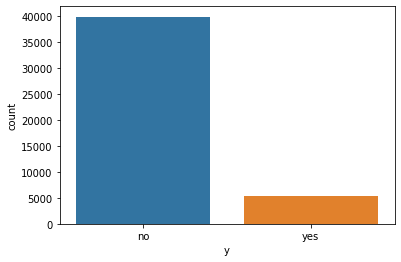

In [17]:
sns.countplot(x=df["y"])
plt.show()

In [18]:
df.y = df.y.map({'no':0,'yes':1})

In [19]:
no_percentage = ((len(df[df['y']==0]) / df.shape[0]) * 100)
print('No.of people who have not opted insurance :', round(no_percentage),'%')

No.of people who have not opted insurance : 88 %


In [20]:
yes_percentage = ((len(df[df['y']==1]) / df.shape[0]) * 100)
print('No.of people who have opted insurance :', round(yes_percentage),'%')

No.of people who have opted insurance : 12 %


In [21]:
df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y'],
      dtype='object')

In [22]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [23]:
df.job = df.job.replace(['admin.'],'admin')

In [24]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [25]:
df.job.value_counts()

blue-collar      9730
management       9457
technician       7596
admin            5170
services         4153
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [26]:
df.job = df.job.replace(['unknown'],df.job.mode())

In [27]:
df.job.value_counts()

blue-collar      10018
management        9457
technician        7596
admin             5170
services          4153
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: job, dtype: int64

In [28]:
df.groupby('job')['y'].mean()

job
admin            0.122050
blue-collar      0.074067
entrepreneur     0.082717
housemaid        0.087903
management       0.137570
retired          0.227915
self-employed    0.118429
services         0.088851
student          0.286780
technician       0.110585
unemployed       0.155027
Name: y, dtype: float64

In [29]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

In [30]:
df.marital.value_counts()

married     27210
single      12788
divorced     5207
Name: marital, dtype: int64

In [31]:
df.groupby('marital')['y'].mean()

marital
divorced    0.119455
married     0.101250
single      0.149515
Name: y, dtype: float64

In [32]:
df.education_qual.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [33]:
df.education_qual.value_counts()

secondary    23199
tertiary     13299
primary       6850
unknown       1857
Name: education_qual, dtype: int64

In [34]:
df.education_qual = df.education_qual.replace(['unknown'],df.education_qual.mode())

In [35]:
df.education_qual.value_counts()

secondary    25056
tertiary     13299
primary       6850
Name: education_qual, dtype: int64

In [36]:
df.groupby('education_qual')['y'].mean()

education_qual
primary      0.086277
secondary    0.107838
tertiary     0.150086
Name: y, dtype: float64

In [37]:
df.call_type.unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [38]:
df.call_type.value_counts()

cellular     29282
unknown      13017
telephone     2906
Name: call_type, dtype: int64

In [39]:
df.groupby('call_type')['y'].mean()

call_type
cellular     0.149204
telephone    0.134205
unknown      0.040716
Name: y, dtype: float64

In [40]:
df.mon.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [41]:
df.mon.value_counts()

may    13765
jul     6894
aug     6245
jun     5339
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: mon, dtype: int64

In [42]:
df.groupby('mon')['y'].mean()

mon
apr    0.196794
aug    0.110168
dec    0.467290
feb    0.166478
jan    0.101212
jul    0.090949
jun    0.102266
mar    0.519916
may    0.067199
nov    0.101511
oct    0.437669
sep    0.464594
Name: y, dtype: float64

In [43]:
df.num_calls.unique()

array([1, 2, 3, 5, 4, 6])

In [44]:
df.num_calls.value_counts()

1    17542
2    12503
3     5521
6     4355
4     3520
5     1764
Name: num_calls, dtype: int64

In [45]:
df.groupby('num_calls')['y'].mean()

num_calls
1    0.145992
2    0.112053
3    0.111936
4    0.090057
5    0.078798
6    0.058094
Name: y, dtype: float64

In [46]:
df.prev_outcome.unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [47]:
df.prev_outcome.value_counts()

unknown    36953
failure     4901
other       1840
success     1511
Name: prev_outcome, dtype: int64

In [48]:
df[df['prev_outcome']=='success'].y.value_counts()

1    978
0    533
Name: y, dtype: int64

In [49]:
df.groupby('prev_outcome')['y'].mean()

prev_outcome
failure    0.126097
other      0.166848
success    0.647253
unknown    0.091630
Name: y, dtype: float64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45205 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45205 non-null  int64 
 1   job             45205 non-null  object
 2   marital         45205 non-null  object
 3   education_qual  45205 non-null  object
 4   call_type       45205 non-null  object
 5   day             45205 non-null  int64 
 6   mon             45205 non-null  object
 7   dur             45205 non-null  int64 
 8   num_calls       45205 non-null  int64 
 9   prev_outcome    45205 non-null  object
 10  y               45205 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.1+ MB


In [51]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,secondary,unknown,5,may,92,1,unknown,0
4,33,blue-collar,single,secondary,unknown,5,may,198,1,unknown,0


# Exploratory Data Analysis

In [52]:
import warnings 
warnings.filterwarnings("ignore")

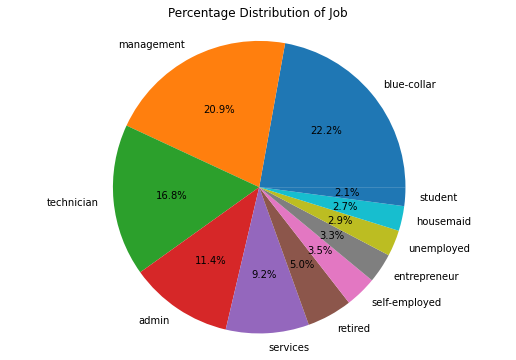

In [53]:
plt.figure(figsize=(9,6))
df_job = df.job.value_counts()
df_job = df_job.reset_index()
plt.pie(df_job['job'],labels=df_job['index'],autopct='%1.1f%%')
plt.title('Percentage Distribution of Job')
plt.axis('equal')
plt.show()

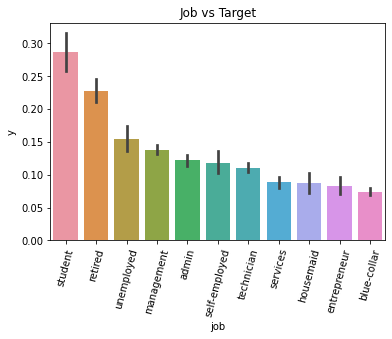

In [54]:
sns.barplot(x='job',y='y',data=df,order=df.groupby('job')['y'].mean().reset_index().sort_values('y', ascending = False)['job'])
plt.xticks(rotation=75)
plt.title('Job vs Target')
plt.show()

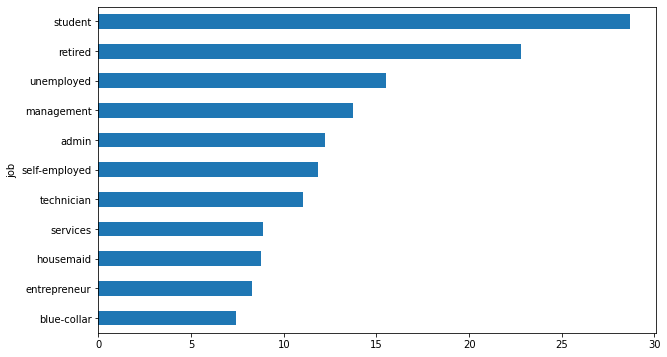

In [55]:
plt.figure(figsize=(10,6))
(df.groupby('job')['y'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

From this, we can see that the people who are getting contacted more are working in blue-collar jobs whereas the students are the ones who opts for insurance more.

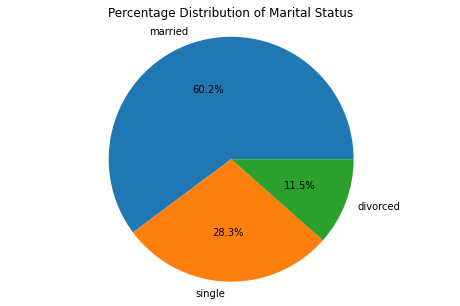

In [56]:
plt.figure(figsize=(8,5))
df_marital = df.marital.value_counts()
df_marital = df_marital.reset_index()
plt.pie(df_marital['marital'],labels=df_marital['index'], autopct='%1.1f%%')
plt.title('Percentage Distribution of Marital Status')
plt.axis('equal')
plt.show()

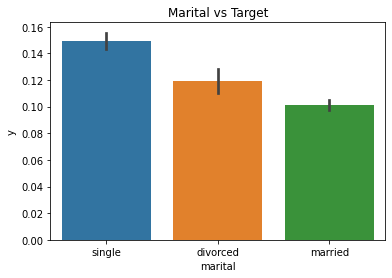

In [57]:
sns.barplot(x='marital',y='y',data=df,order=df.groupby('marital')['y'].mean().reset_index().sort_values('y', ascending = False)['marital'])
plt.title('Marital vs Target')
plt.show()

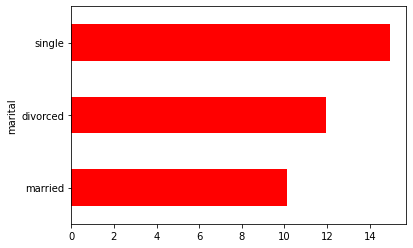

In [58]:
(df.groupby('marital')['y'].mean()*100).sort_values().plot(kind = 'barh', color = 'r')
plt.show()

From this, we can see that the people who are married are contacted more but the single ones are opting for insurance more.

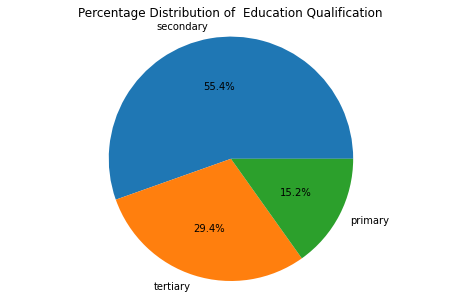

In [59]:
plt.figure(figsize=(8,5))
df_ed = df.education_qual.value_counts()
df_ed = df_ed.reset_index()
plt.pie(df_ed['education_qual'], labels=df_ed['index'],autopct='%1.1f%%')
plt.title('Percentage Distribution of  Education Qualification')
plt.axis('equal')
plt.show()

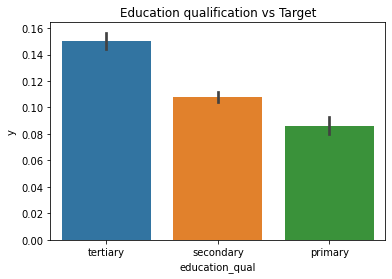

In [60]:
sns.barplot(x='education_qual',y='y',data=df,order=df.groupby('education_qual')['y'].mean().reset_index().sort_values('y', ascending = False)['education_qual'])
plt.title('Education qualification vs Target')
plt.show()

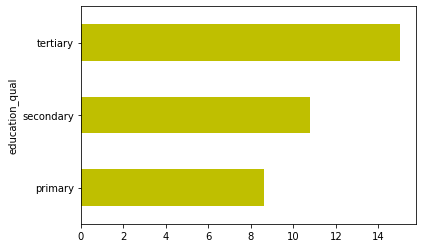

In [61]:
(df.groupby('education_qual')['y'].mean()*100).sort_values().plot(kind = 'barh', color = 'y')
plt.show()

From this, we can see that the people who have secondary education are contacted more whereas the people who have tertiary education are opting more for insurance.

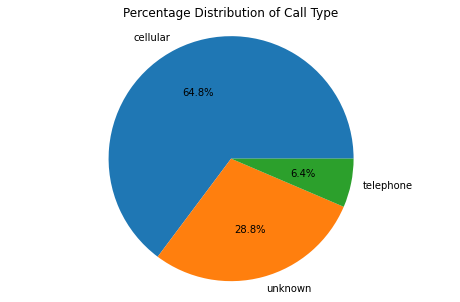

In [62]:
plt.figure(figsize=(8,5))
df_call = df.call_type.value_counts()
df_call = df_call.reset_index()
plt.pie(df_call['call_type'], labels=df_call['index'], autopct='%1.1f%%')
plt.title('Percentage Distribution of Call Type')
plt.axis('equal')
plt.show()

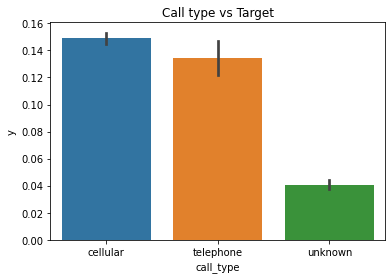

In [63]:
sns.barplot(x='call_type',y='y',data=df,order=df.groupby('call_type')['y'].mean().reset_index().sort_values('y', ascending = False)['call_type'])
plt.title('Call type vs Target')
plt.show()

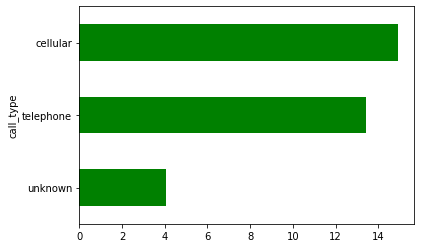

In [64]:
(df.groupby('call_type')['y'].mean()*100).sort_values().plot(kind = 'barh', color = 'g')
plt.show()

From this, we can see that people are opting for insurance more when contacted in cellular mode.

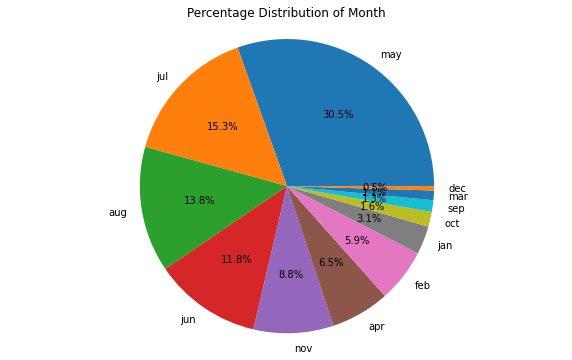

In [65]:
plt.figure(figsize=(10,6))
df_month = df.mon.value_counts()
df_month = df_month.reset_index()
plt.pie(df_month['mon'], labels=df_month['index'], autopct='%1.1f%%')
plt.title('Percentage Distribution of Month')
plt.axis('equal')
plt.show()

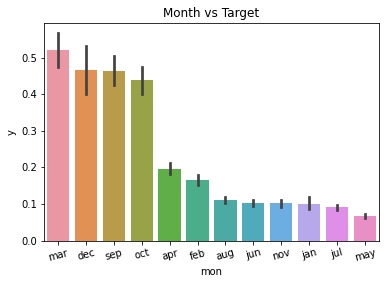

In [66]:
sns.barplot(x='mon',y='y',data=df,order=df.groupby('mon')['y'].mean().reset_index().sort_values('y', ascending = False)['mon'])
plt.xticks(rotation=15)
plt.title('Month vs Target')
plt.show()

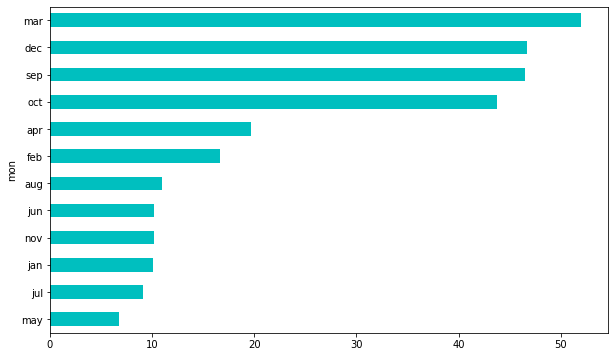

In [67]:
plt.figure(figsize=(10,6))
(df.groupby('mon')['y'].mean()*100).sort_values().plot(kind = 'barh', color ='c')
plt.show()

From this, we can see that people are getting contacted more in the month of may whereas there is an higher conversion rate in the month of march.

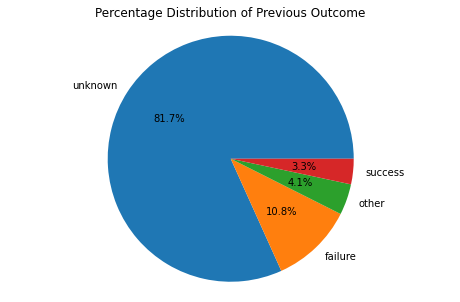

In [68]:
plt.figure(figsize=(8,5))
df_prev = df.prev_outcome.value_counts()
df_prev = df_prev.reset_index()
plt.pie(df_prev['prev_outcome'], labels=df_prev['index'], autopct='%1.1f%%')
plt.title('Percentage Distribution of Previous Outcome')
plt.axis('equal')
plt.show()

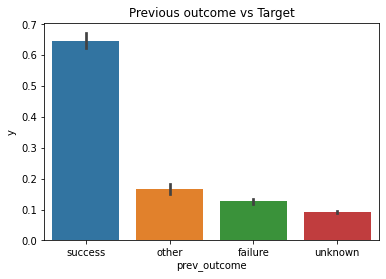

In [69]:
sns.barplot(x='prev_outcome',y='y',data=df,order=df.groupby('prev_outcome')['y'].mean().reset_index().sort_values('y', ascending = False)['prev_outcome'])
plt.title('Previous outcome vs Target')
plt.show()

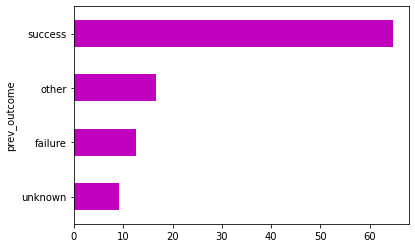

In [70]:
(df.groupby('prev_outcome')['y'].mean()*100).sort_values().plot(kind = 'barh', color ='m')
plt.show()

From this, we can see that when the previous outcome is success, there is an higher conversion percentage.

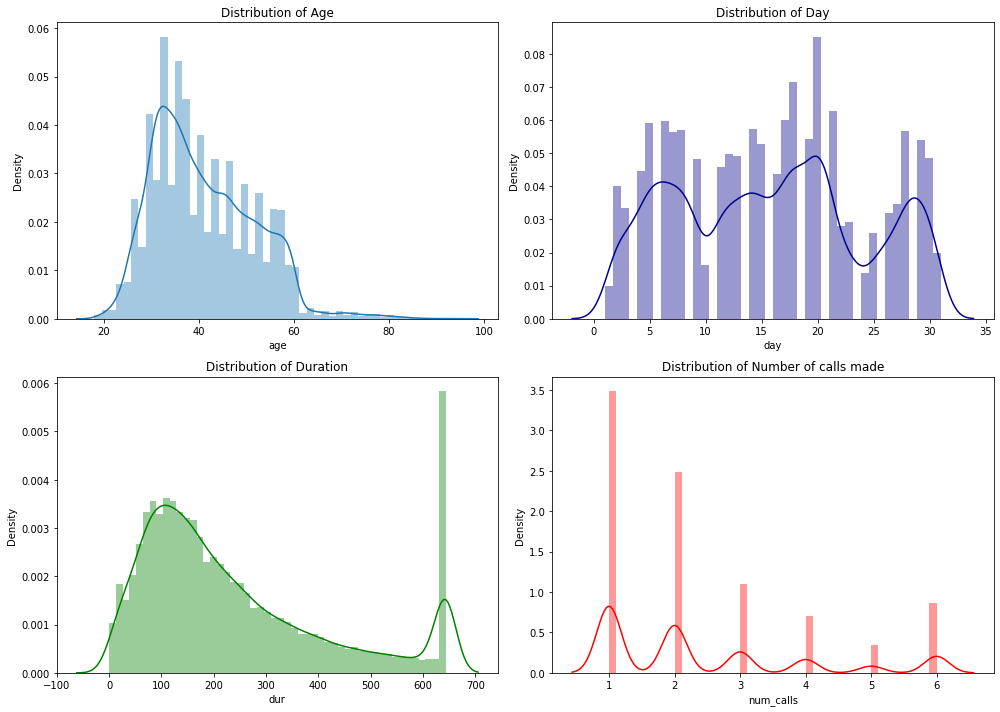

In [71]:
plt.figure(figsize=(14,10))

# Age
plt.subplot(221)
plt.title('Distribution of Age')
sns.distplot(df['age'])

# Day
plt.subplot(222)
plt.title('Distribution of Day')
sns.distplot(df['day'],color = 'darkblue')

# Duration
plt.subplot(223)
plt.title('Distribution of Duration')
sns.distplot(df['dur'],color = 'green')

# Number of calls
plt.subplot(224)
plt.title('Distribution of Number of calls made')
sns.distplot(df['num_calls'],color = 'red')

plt.tight_layout()
plt.show()

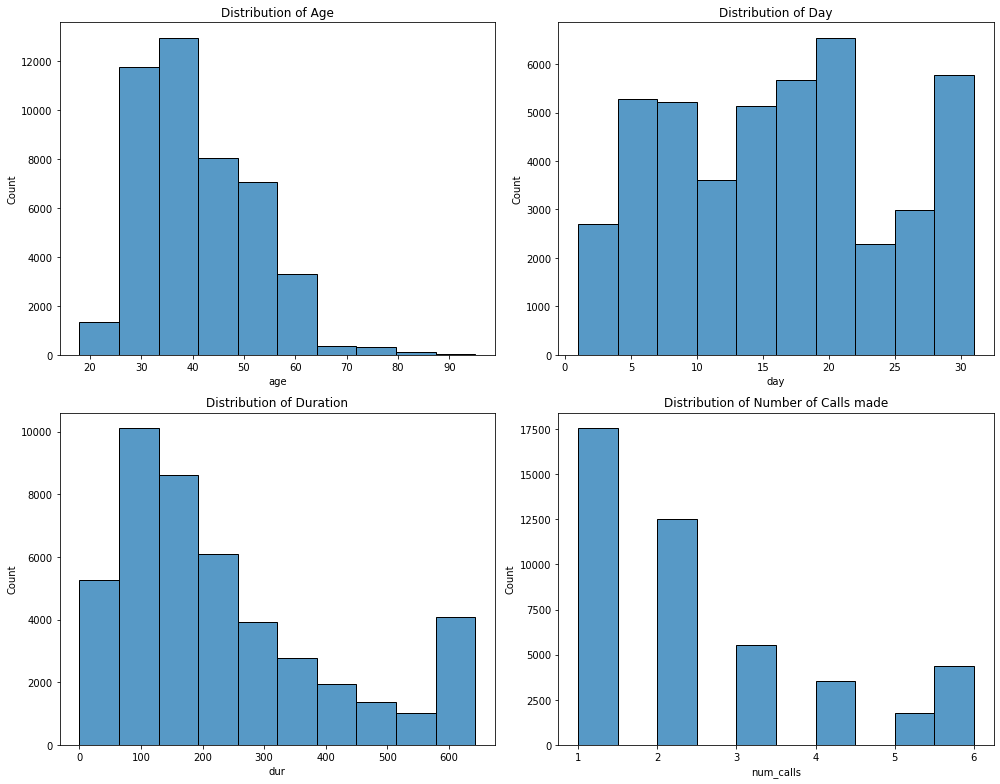

In [72]:
plt.figure(figsize = (14,11))

# Age
plt.subplot(221)
sns.histplot(df['age'], bins = 10)
plt.title('Distribution of Age')

# Day
plt.subplot(222)
sns.histplot(df['day'], bins = 10)
plt.title('Distribution of Day')

# Duration
plt.subplot(223)
sns.histplot(df['dur'], bins = 10)
plt.title('Distribution of Duration')

# Number of calls
plt.subplot(224)
sns.histplot(df['num_calls'], bins = 10)
plt.title('Distribution of Number of Calls made')

plt.tight_layout()
plt.show()

# Data encoding

In [73]:
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                  int64
dtype: object

In [74]:
#job
df['job']=df['job'].map({'blue-collar':0,'entrepreneur':1,'housemaid':2,'services':3,'technician':4,'self-employed':5,'admin':6,'management':7,'unemployed':8,'retired':9,'student':10})

#marital
df['marital']=df['marital'].map({'married':0,'divorced':1,'single':2})

#education_qual
df['education_qual']=df['education_qual'].map({'primary':0,'secondary':1,'tertiary':2})

#call_type
df['call_type']=df['call_type'].map({'unknown':0,'telephone':1,'cellular':2})

#mon
df['mon']=df['mon'].map({'may':0,'jul':1,'jan':2,'nov':3,'jun':4,'aug':5,'feb':6,'apr':7,'oct':8,'sep':9,'dec':10,'mar':11})

#prev_outcome
df['prev_outcome']=df['prev_outcome'].map({'unknown':0,'failure':1,'other':2,'success':3})
     

Since there is an order in these features, we are doing label encoding here.

In [75]:
df.dtypes

age               int64
job               int64
marital           int64
education_qual    int64
call_type         int64
day               int64
mon               int64
dur               int64
num_calls         int64
prev_outcome      int64
y                 int64
dtype: object

In [76]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,7,0,2,0,5,0,261,1,0,0
1,44,4,2,1,0,5,0,151,1,0,0
2,33,1,0,1,0,5,0,76,1,0,0
3,47,0,0,1,0,5,0,92,1,0,0
4,33,0,2,1,0,5,0,198,1,0,0


# Splitting the dataset

In [77]:
X = df.drop('y',axis=1).values
y = df['y'].values

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [79]:
X_train.shape, X_test.shape

((33903, 10), (11302, 10))

# Balancing dataset using SMOTEENN

In [80]:
df.shape

(45205, 11)

In [81]:
len(X_train), len(y_train)

(33903, 33903)

In [82]:
smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [83]:
len(X_smt), len(y_smt)

(50435, 50435)

In [84]:
balanced_df = pd.DataFrame(X_smt, columns=list(i for i in list(df.columns) if i != 'y'))
balanced_df['y'] = y_smt
balanced_df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,56,8,0,0,2,19,3,149,1,0,0
1,36,4,0,1,0,8,0,380,2,0,0
2,32,0,0,1,0,3,4,200,1,0,0
3,58,0,1,1,0,25,4,67,2,0,0
4,44,7,0,1,2,12,5,112,5,0,0


In [85]:
balanced_df.shape

(50435, 11)

In [86]:
balanced_df.y.value_counts()

1    28321
0    22114
Name: y, dtype: int64

In [87]:
(len(balanced_df[balanced_df['y']==0]) / balanced_df.shape[0]) * 100

43.84653514424507

In [88]:
(len(balanced_df[balanced_df['y']==1]) / balanced_df.shape[0]) * 100

56.15346485575493

# Model : Logistic Regression

In [89]:
lr = LogisticRegression()
lr.fit(X_smt,y_smt)

LogisticRegression()

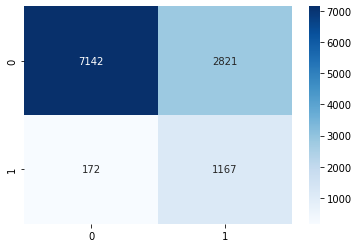

In [90]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)), annot=True,  fmt='3g', cmap="Blues")
plt.show()

In [91]:
lr_score = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('Auroc for Logistic Regression :', lr_score)

Auroc for Logistic Regression : 0.8671738157096117


# Model : KNN

In [92]:
knn = KNeighborsClassifier()
knn.fit(X_smt, y_smt)
knn.score(X_test, y_test)

0.749513360467174

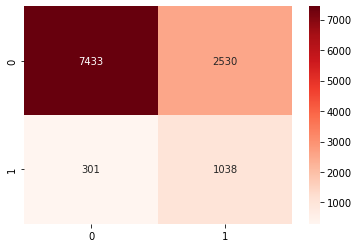

In [93]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test)), annot=True,  fmt='3g', cmap="Reds")
plt.show()

In [94]:
knn_score =  roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
print('Auroc for KNN:', knn_score)

Auroc for KNN: 0.801322548395456


# Model : Decision Tree

In [95]:
dt = DecisionTreeClassifier()
dt.fit(X_smt, y_smt)
dt.score(X_test, y_test)

0.8207396920898956

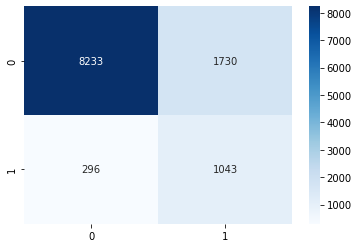

In [96]:
sns.heatmap(confusion_matrix(y_test, dt.predict(X_test)), annot=True,  fmt='3g', cmap="Blues")
plt.show()

In [97]:
dt_score = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])
print('Auroc for Decision Tree:', dt_score)

Auroc for Decision Tree: 0.8026485149646673


# Model : Random Forest

In [98]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, max_features="sqrt")
rf.fit(X_smt, y_smt)

RandomForestClassifier(max_depth=4)

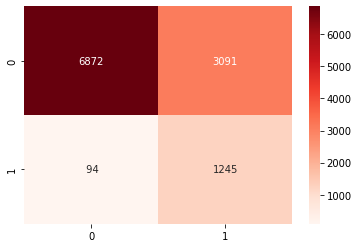

In [99]:
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True,  fmt='3g', cmap="Reds")
plt.show()

In [100]:
rf_score = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print('Auroc for Random Forest :', rf_score)

Auroc for Random Forest : 0.886682517697857


# Model : XGBoost

In [101]:
xg = xgb.XGBClassifier(n_estimators=100, verbosity=0)
xg.fit(X_smt, y_smt)
xg.score(X_smt, y_smt)

0.9798750867453158

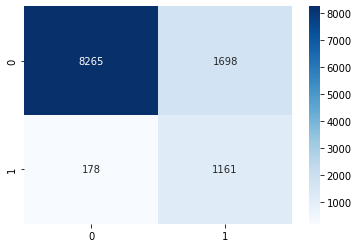

In [102]:
sns.heatmap(confusion_matrix(y_test, xg.predict(X_test)), annot=True,  fmt='3g', cmap="Blues")
plt.show()

In [103]:
xg_score = roc_auc_score(y_test, xg.predict_proba(X_test)[:,1])
print('Auroc for XGBoost:', xg_score)

Auroc for XGBoost: 0.9148745429035902


In [104]:
pd.DataFrame({"Model":["Logistic Regression", "KNN","Decision Tree", "Random Forest", "XGBoost"],"AUROC":[lr_score,knn_score,dt_score,rf_score,xg_score]})

,Model,AUROC
0,Logistic Regression,0.867174
1,KNN,0.801323
2,Decision Tree,0.802649
3,Random Forest,0.886683
4,XGBoost,0.914875


# Hyperparameter tuning

In [105]:
X = df.drop('y',axis=1).values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
pipeline = imbpipeline(steps = [['smoteenn', SMOTEENN()],
                               ['classifier', XGBClassifier(learning_rate=0.5, n_estimators=100, verbosity=0)]])
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)
param_grid = {'classifier__C':[0.1, 0.15, 0.2, 0.25, 0.3, 1]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score} Test score: {test_score}')

Cross-validation score: 0.9110651127250966 Test score: 0.908483040210527


In [106]:
lr = grid_search.best_params_["classifier__C"]
print("Learning Rate :", lr)

Learning Rate : 0.25


# Feature importance

In [107]:
importance = xg.feature_importances_ 
feature_importances = list(zip(importance,['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'])) 
feature_importances = sorted(feature_importances, key = lambda x: x[0], reverse = True) 
feature_importances

[(0.26968327, 'call_type'),
 (0.19067955, 'dur'),
 (0.1497338, 'mon'),
 (0.13657309, 'prev_outcome'),
 (0.06400193, 'num_calls'),
 (0.047150858, 'job'),
 (0.04434805, 'day'),
 (0.037656754, 'marital'),
 (0.03604013, 'age'),
 (0.024132608, 'education_qual')]

In [108]:
imp_fts = pd.DataFrame({'ft':['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 'imp':xg.feature_importances_})
imp_fts.sort_values('imp', ascending=False, inplace=True)

In [109]:
imp_fts.iloc[0:5,0].values

array(['call_type', 'dur', 'mon', 'prev_outcome', 'num_calls'],
      dtype=object)

From this, we can see that


*   call_type
*   duration
*   prev_outcome
*   month
*   num_calls

are the most important features here.



# Feature Combination

In [110]:
max_roc=[]
best_comb=[]

In [111]:
comb_1 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 1))
auc_1 = []
for i in comb_1:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_1.append(g)
max_roc.append(max(auc_1))
ind = auc_1.index(max(auc_1))
best_ft = comb_1[ind]
best_comb.append(best_ft)

In [112]:
comb_2 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 2))
auc_2 = []
for i in comb_2:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_2.append(g)
max_roc.append(max(auc_2))
ind = auc_2.index(max(auc_2))
best_ft = comb_2[ind]
best_comb.append(best_ft)

In [113]:
comb_3 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 3))
auc_3 = []
for i in comb_3:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_3.append(g)
max_roc.append(max(auc_3))
ind = auc_3.index(max(auc_3))
best_ft = comb_3[ind]
best_comb.append(best_ft)

In [114]:
comb_4 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 4))
auc_4 = []
for i in comb_4:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_4.append(g)
max_roc.append(max(auc_4))
ind = auc_4.index(max(auc_4))
best_ft = comb_4[ind]
best_comb.append(best_ft)

In [ ]:
comb_5 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 5))
auc_5 = []
for i in comb_5:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_5.append(g)
max_roc.append(max(auc_5))
ind = auc_5.index(max(auc_5))
best_ft = comb_5[ind]
best_comb.append(best_ft)

In [116]:
comb_6 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 6))
auc_6 = []
for i in comb_6:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_6.append(g)
max_roc.append(max(auc_6))
ind = auc_6.index(max(auc_6))
best_ft = comb_6[ind]
best_comb.append(best_ft)

In [117]:
comb_7 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 7))
auc_7 = []
for i in comb_7:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_7.append(g)
max_roc.append(max(auc_7))
ind = auc_7.index(max(auc_7))
best_ft = comb_7[ind]
best_comb.append(best_ft)

In [118]:
comb_8 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 8))
auc_8 = []
for i in comb_8:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_8.append(g)
max_roc.append(max(auc_8))
ind = auc_8.index(max(auc_8))
best_ft = comb_8[ind]
best_comb.append(best_ft)

In [119]:
comb_9 = list(combinations(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'], 9))
auc_9 = []
for i in comb_9:
    x = df.drop('y',axis=1).values
    y = df['y'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
    smt = SMOTEENN(sampling_strategy="all")
    x_smt, y_smt = smt.fit_resample(x_train, y_train)
    xg = xgb.XGBClassifier(learning_rate=lr, n_estimators=100, verbosity=0)
    xg.fit(x_smt, y_smt)
    g = roc_auc_score(y_test, xg.predict_proba(x_test)[:,1])
    auc_9.append(g)
max_roc.append(max(auc_9))
ind = auc_9.index(max(auc_9))
best_ft = comb_9[ind]
best_comb.append(best_ft)

In [120]:
ind = max_roc.index(max(max_roc))
best_ft = [*best_comb[ind]]
best_ft

['job', 'education_qual', 'call_type', 'dur', 'num_calls', 'prev_outcome']

In [128]:
max_roc

[0.9199905145929339,
 0.9204568530481446,
 0.9222818877008919,
 0.9220681486550478,
 0.9227514360624028,
 0.9255783916631415,
 0.9221589717619112,
 0.9212036782776745,
 0.9167505209243499]

# Fitting the important features alone in model

In [125]:
X_imp = df.loc[:, best_ft].values
y = df['y'].values
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size = 0.25)
smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X_train, y_train)
xgg = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0)
xgg.fit(X_smt,y_smt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [129]:
print('Auroc for XGBoost with important features :', roc_auc_score(y_test, xgg.predict_proba(X_test)[:,1]))

Auroc for XGBoost with important features : 0.8475035145728947


In [130]:
max(max_roc)

0.9255783916631415

For the XG Boost model,  I have witnessed that the combination of ['marital', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome'] as the best feature combination which yields around 0.92 AUROC score.

# Model deployment

In [131]:
pickle_file = open("Customer_Conversion_Prediction.pkl","wb")
pickle.dump(xgg, pickle_file)
pickle_file.close()

In [132]:
pickle_open = open("Customer_Conversion_Prediction.pkl","rb")
p_xg=pickle.load(pickle_open)

# Observations:

* The telephonic marketing campaigns focus mostly on people with 'Blue collar' job title, whereas from the analysis, we can see that the 'Students' are subscribing more to the insurance.

* It also focus mainly on 'Married' people but the 'Single' people are more likely converted.

* They are targetting more people in the month of 'May' but as we can see from the analysis, people who are contacted in the month of 'March' are most likely converted.